# Probabilistic Partial Least Squares

PPLS is take to data, comparing it with standard PLS in two ways:
* Simulation 1: Generate synthetic data and compare the fit of all models
* Simulation 2: Generate synthetic data with additional noise and compare the fit of all models
* Simulation 3: Generate synthetic data with missing observations and compare to PLS on imputed data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from PPLS import generate_synthetic_data, ProbabilisticPLS, ProbabilisticPLS_Old

# Generate synthetic data
seed_value = None
n, p, q, k = 1000, 10, 2, 5
true_sigma_x, true_sigma_y = 1.0, 1.0
X, Y, T, P_true, Q_true = generate_synthetic_data(n, p, q, k, true_sigma_x, true_sigma_y, seed_value)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_pred_pls = pls.predict(X)

# Apply PPLS
ppls_model = ProbabilisticPLS_Old(n_components=k)
ppls_model.fit(X, Y)
Y_pred_ppls = ppls_model.predict(X)

# Apply stacked PPLS
predict_method = "mean"
prediction_variance = False
stacked_model_standardized = ProbabilisticPLS(n_components=k)
stacked_model_standardized.fit(X, Y, standardize = True, track_r2 = True)
Y_fitted_stacked_standardized = stacked_model_standardized.fitted(X, Y, standardize = False)
Y_fitted_stacked_doublestandardized = stacked_model_standardized.fitted(X, Y, standardize = True)
Y_pred_stacked_standardized = stacked_model_standardized.predict(X, standardize = False, method = predict_method)
Y_pred_stacked_doublestandardized = stacked_model_standardized.predict(X, standardize = True, method = predict_method)
stacked_model_raw = ProbabilisticPLS(n_components=k)
stacked_model_raw.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_stacked_raw = stacked_model_raw.fitted(X, Y, standardize = False)
Y_pred_stacked_raw = stacked_model_raw.predict(X, standardize = False, method = predict_method)

# Compute R-squared for all models and compare them
r2_pls = r2_score(Y, Y_pred_pls, multioutput = "raw_values")
r2_ppls = r2_score(Y, Y_pred_ppls, multioutput = "raw_values")
r2_stacked_standardized = r2_score(Y, Y_fitted_stacked_standardized, multioutput = "raw_values")
r2_stacked_doublestandardized = r2_score(Y, Y_fitted_stacked_doublestandardized, multioutput = "raw_values")
r2_loading_standardized = r2_score(Y, Y_pred_stacked_standardized, multioutput = "raw_values")
r2_loading_doublestandardized = r2_score(Y, Y_pred_stacked_doublestandardized, multioutput = "raw_values")
r2_stacked_raw = r2_score(Y, Y_fitted_stacked_raw, multioutput = "raw_values")
r2_loading_raw = r2_score(Y, Y_pred_stacked_raw, multioutput = "raw_values")
r2_results = {"pls": r2_pls, "ppls": r2_ppls, "stacked_raw": r2_stacked_raw, "loading_raw": r2_loading_raw,
              "stacked_standardized": r2_stacked_standardized, "stacked_doublestandardized": r2_stacked_doublestandardized,
              "loading_standardized": r2_loading_standardized, "loading_doublestandardized": r2_loading_doublestandardized}

# Print true values and estimated parameters for comparison
print("True P:\n", P_true)
print("True Q:\n", Q_true)
print("PLS Regression Coefficients:\n", pls.coef_)
print("PLS Loadings X:\n", pls.x_loadings_)
print("PLS Loadings Y:\n", pls.y_loadings_)
print("Estimated P (PPLS):\n", ppls_model.P_)
print("Estimated Q (PPLS):\n", ppls_model.Q_)
print("Estimated P (Stacked PPLS):\n", stacked_model_raw.P_)
print("Estimated Q (Stacked PPLS):\n", stacked_model_raw.Q_)

print("True sigma_x:", true_sigma_x)
print("True sigma_y:", true_sigma_y)
print("Estimated sigma_x (PPLS):", np.sqrt(ppls_model.sigma_x_))
print("Estimated sigma_y (PPLS):", np.sqrt(ppls_model.sigma_y_))
print("Estimated sigma_x (Stacked PPLS):", np.sqrt(stacked_model_raw.sigma2_x_))
print("Estimated sigma_y (Stacked PPLS):", np.sqrt(stacked_model_raw.sigma2_y_))

print(r2_results)

True P:
 [[ 0.31718563  1.69153387 -0.85684274  1.3358376   0.99994137]
 [ 0.67770672 -0.31279333 -1.26427735  0.0530626   0.16809165]
 [ 0.13881766 -0.17880756  1.18914877 -0.46530488 -0.35034942]
 [-0.06792422 -0.46657324 -0.01013418  2.41693388  0.19727437]
 [-0.02426814  0.85285017 -1.76095404  0.30860184 -0.56588638]
 [-0.00971208  0.45563919 -1.59417697 -2.13549505 -1.32689383]
 [-1.1880418  -1.16848388  1.2018985  -1.02579192  0.49712993]
 [-0.34857692  0.38090852  0.05878353 -1.55436686 -1.28061308]
 [-0.08765288  1.31046568  0.88512218  1.09998495  0.72107678]
 [-0.3111277   0.66621136 -2.56585523  0.53782867 -1.34281195]]
True Q:
 [[ 0.36797093  0.68150006  0.23235395  1.26493559 -0.55779603]
 [ 0.10729742 -0.30414455  1.51381848 -1.32397672  1.36661071]]
PLS Regression Coefficients:
 [[ 0.01878973 -0.27584623  0.43941045  0.59889429  0.07119699 -0.30343847
  -0.83761679  0.2454163   0.41205724  0.33304861]
 [ 0.37989986  0.18726362 -0.05049157 -1.10339634 -0.57634557  0.0576

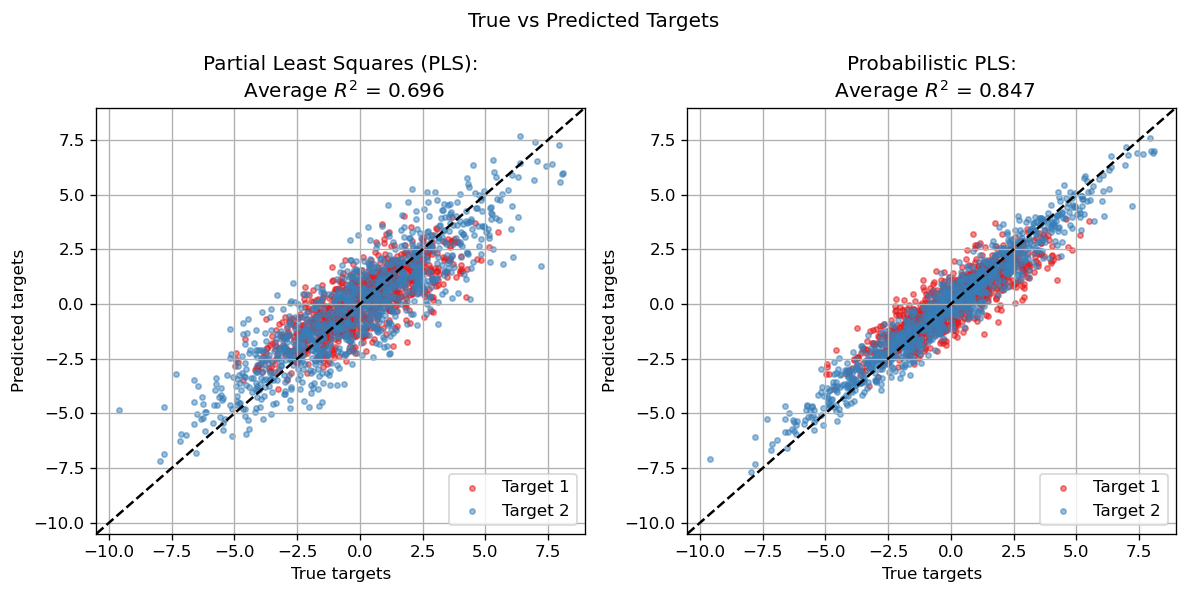

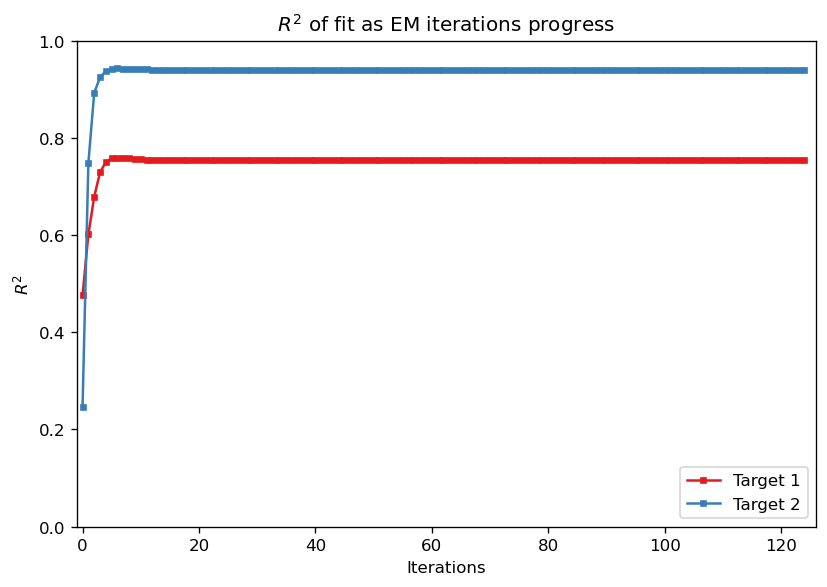

In [2]:
# Obtain ranges, colormaps and names for the plots
def variable_plot_range(x, percentage = 0.05):
    min_value = np.min(x)
    max_value = np.max(x)
    range_value = max_value - min_value
    adjustment = percentage * range_value
    return (min_value - adjustment, max_value + adjustment)
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_pred_pls, Y_pred_ppls, Y_pred_stacked_standardized, Y_pred_stacked_raw])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_pred_pls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# # Probabilistic PLS
# plt.subplot(2, 2, 2)
# for i in range(q):
#     plt.scatter(Y[:, i], Y_pred_ppls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
# plt.plot(y_range, y_range, "k--")
# plt.axis(axis_range)
# plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ppls):.2f}')
# # plt.xlabel('True $Y$')
# # plt.ylabel('Predicted $Y$')
# plt.legend(loc="lower right")
# plt.grid(True)

# # Stacked Probabilistic PLS (After standardization)
# plt.subplot(2, 2, 3)
# for i in range(q):
#     plt.scatter(Y[:, i], Y_pred_stacked_standardized[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
# plt.plot(y_range, y_range, "k--")
# plt.axis(axis_range)
# plt.title(f'Probabilistic PLS Stacked (Standardized):\n Average $R^2$ = {np.mean(r2_stacked_standardized):.2f}')
# plt.xlabel('True $Y$')
# plt.ylabel('Predicted $Y$')
# plt.legend(loc="lower right")
# plt.grid(True)

# Stacked Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_pred_stacked_raw[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_stacked_raw):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Save resulting plot
plt.tight_layout()
plt.savefig('single_fit_comparison.png', bbox_inches='tight')
plt.show()

# Plot path of R-squared in stacked PPLS
max_iterations = max([stacked_model_standardized.r2_array_.shape[0], stacked_model_raw.r2_array_.shape[0]])
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
# plt.subplot(1, 2, 1)
# for i in range(q):
#     plt.plot(stacked_model_standardized.r2_array_[:, i], "s-", color=colors(i), label=names[i], markersize=3)
# plt.axis([-1, max_iterations+1, 0, 1])
# plt.title("PPLS after Standardization")
# plt.xlabel("Iterations")
# plt.ylabel("$R^2$")
# plt.legend(loc="lower right")

# plt.subplot(1, 2, 2)
for i in range(q):
    plt.plot(stacked_model_raw.r2_array_[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('rsquared_em_iterations.png', bbox_inches='tight')
plt.show()

In [3]:
# Exploration of differences between stacked and unstacked
max_iter = 1000
tolerance = 1e-6
standardize = False

# One loop of unstacked EM
P = np.random.randn(p, k)
Q = np.random.randn(q, k)
sigma_x = np.var(X, axis=0).mean()  # Mean variance across features
sigma_y = np.var(Y, axis=0).mean()  # Mean variance across targets

# E-step: Compute posterior mean M and covariance Sigma
A = (P.T @ P) / sigma_x + (Q.T @ Q) / sigma_y + np.eye(k)
Sigma_unstacked = np.linalg.inv(A)
B = (X @ P) / sigma_x + (Y @ Q) / sigma_y
M_unstacked = np.linalg.solve(A, B.T).T

# M-step: Update P, Q, sigma_x, and sigma_y
V_new = M_unstacked.T @ M_unstacked + n * Sigma_unstacked
P_new = (X.T @ M_unstacked) @ np.linalg.inv(V_new)
Q_new = (Y.T @ M_unstacked) @ np.linalg.inv(V_new)
sigma_x_new = (1 / (n * p)) * (np.linalg.norm(X - M_unstacked @ P_new.T, 'fro')**2) + (1 / p) * np.trace(P_new.T @ P_new @ Sigma_unstacked)
sigma_y_new = (1 / (n * q)) * (np.linalg.norm(Y - M_unstacked @ Q_new.T, 'fro')**2) + (1 / q)  * np.trace(Q_new.T @ Q_new @ Sigma_unstacked)

P_distance = np.linalg.norm(P - P_new, "fro")
Q_distance = np.linalg.norm(Q - Q_new, "fro")
sigma_x_distance = abs(sigma_x - sigma_x_new)
sigma_y_distance = abs(sigma_y - sigma_y_new)
theta_distance_unstacked = P_distance + Q_distance + sigma_x_distance + sigma_y_distance

convergence_unstacked = (P_distance < tolerance and Q_distance < tolerance
                         and sigma_x_distance < tolerance and sigma_y_distance < tolerance)

# One loop of stacked EM
d = p + q
rng = np.random.default_rng(seed=seed_value)
V_prior_inv = np.eye(k)
L0 = np.vstack([P, Q])
sigma2_x0 = sigma_x
sigma2_y0 = sigma_y
if standardize:
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)
Z = np.hstack([X, Y])

# Expectation step: Update posterior paramater for factors
L_scaled = np.vstack([L0[:p] / sigma2_x0, L0[p:] / sigma2_y0])
Sigma_stacked = np.linalg.inv(V_prior_inv + L0.T @ L_scaled)
M_stacked = Z @ L_scaled @ Sigma_stacked

# Maximization step: Update factor loadings and variances
V = n * Sigma_stacked + M_stacked.T @ M_stacked
L1 = np.linalg.solve(V, M_stacked.T @ Z).T
P = L1[:p]
Q = L1[p:]
sigma2_x1 = (1/(n * p)) * (np.trace(X.T @ X) - np.trace(P.T @ P @ V))
sigma2_y1 = (1/(n * q)) * (np.trace(Y.T @ Y) - np.trace(Q.T @ Q @ V))

# Compute distance between iterates
P_distance = np.linalg.norm(P - L0[:p], "fro")
Q_distance = np.linalg.norm(Q - L0[p:], "fro")
sigma_x_distance = np.abs(sigma2_x1 - sigma2_x0)
sigma_y_distance = np.abs(sigma2_y1 - sigma2_y0)
theta_distance_stacked = sum([P_distance, Q_distance, sigma_x_distance, sigma_y_distance])

# Comparison
print(Sigma_unstacked); print(Sigma_stacked)
print(M_unstacked); print(M_stacked)
print(P_new); print(P)
print(Q_new); print(Q)
print(sigma_x_new); print(sigma2_x1)
print(sigma_y_new); print(sigma2_y1)
print(theta_distance_unstacked); print(theta_distance_stacked)

# Comparison of predictions
Y_hat_unstacked = M_unstacked @ Q_new.T
Y_hat_stacked = M_stacked @ Q.T
r2_unstacked = r2_score(Y, Y_hat_unstacked, multioutput = "raw_values")
r2_stacked = r2_score(Y, Y_hat_stacked, multioutput = "raw_values")
print(r2_unstacked); print(r2_stacked)


[[ 0.44350246  0.04005764 -0.00966756 -0.08023193 -0.01381467]
 [ 0.04005764  0.35570495 -0.02468458 -0.0719296   0.00598109]
 [-0.00966756 -0.02468458  0.35116296 -0.06354774  0.0113824 ]
 [-0.08023193 -0.0719296  -0.06354774  0.43311025  0.00903372]
 [-0.01381467  0.00598109  0.0113824   0.00903372  0.42116762]]
[[ 0.44350246  0.04005764 -0.00966756 -0.08023193 -0.01381467]
 [ 0.04005764  0.35570495 -0.02468458 -0.0719296   0.00598109]
 [-0.00966756 -0.02468458  0.35116296 -0.06354774  0.0113824 ]
 [-0.08023193 -0.0719296  -0.06354774  0.43311025  0.00903372]
 [-0.01381467  0.00598109  0.0113824   0.00903372  0.42116762]]
[[ 0.01234255 -0.54982944 -0.10331717  0.23245017  0.17063615]
 [-0.01877584 -0.37556292 -0.16098608  0.17164939 -0.23195475]
 [ 0.43411517 -0.39822135  0.04567846  0.21327193 -0.05396503]
 ...
 [ 0.51779631 -0.3502331   0.37344162 -0.8172237   0.03617781]
 [-0.14663668  0.65844231 -0.34889318  0.42486544  0.54760242]
 [ 0.5683658   0.15881211  0.14125126  0.1068184

In [4]:
# Function to evaluate models over a range of noise levels
def evaluate_models_over_noise(n, p, q, k, noise_levels, n_replications):
    n_levels = len(noise_levels)
    r2_pls_results = np.zeros([n_levels, n_levels, n_replications])
    # r2_ppls_results = np.zeros([n_levels, n_levels, n_replications])
    r2_stacked_results = np.zeros([n_levels, n_levels, n_replications])

    for i, sigma_x in enumerate(noise_levels):
        for j, sigma_y in enumerate(noise_levels):
            for l in range(n_replications):
                # Generate synthetic data
                X, Y, _, _, _ = generate_synthetic_data(n, p, q, k, sigma_x, sigma_y, seed_value=None)
                
                # Apply PLS regression
                pls = PLSRegression(n_components=k)
                pls.fit(X, Y)
                Y_pred_pls = pls.predict(X)

                # # Apply PPLS
                # ppls_model = ProbabilisticPLS(n_components=k)
                # ppls_model.fit(X, Y)
                # Y_pred_ppls = ppls_model.predict(X)

                # Apply stacked PPLS
                stacked_model = ProbabilisticPLS(n_components=k)
                stacked_model.fit(X, Y, standardize=False, track_r2=False)
                Y_pred_stacked = stacked_model.fitted(X, Y, standardize=False)

                # Compute R-squared for both models
                r2_pls_results[i, j, l] = r2_score(Y, Y_pred_pls)
                # r2_ppls_results[i, j, l] = r2_score(Y, Y_pred_ppls)
                r2_stacked_results[i, j, l] = r2_score(Y, Y_pred_stacked)

    return r2_pls_results, r2_stacked_results # , r2_ppls_results

# Evaluate models
n_replications = 100
noise_levels = np.linspace(0.1, 5, 20)
r2_pls_results, r2_stacked_results = evaluate_models_over_noise(n, p, q, k, noise_levels, n_replications)


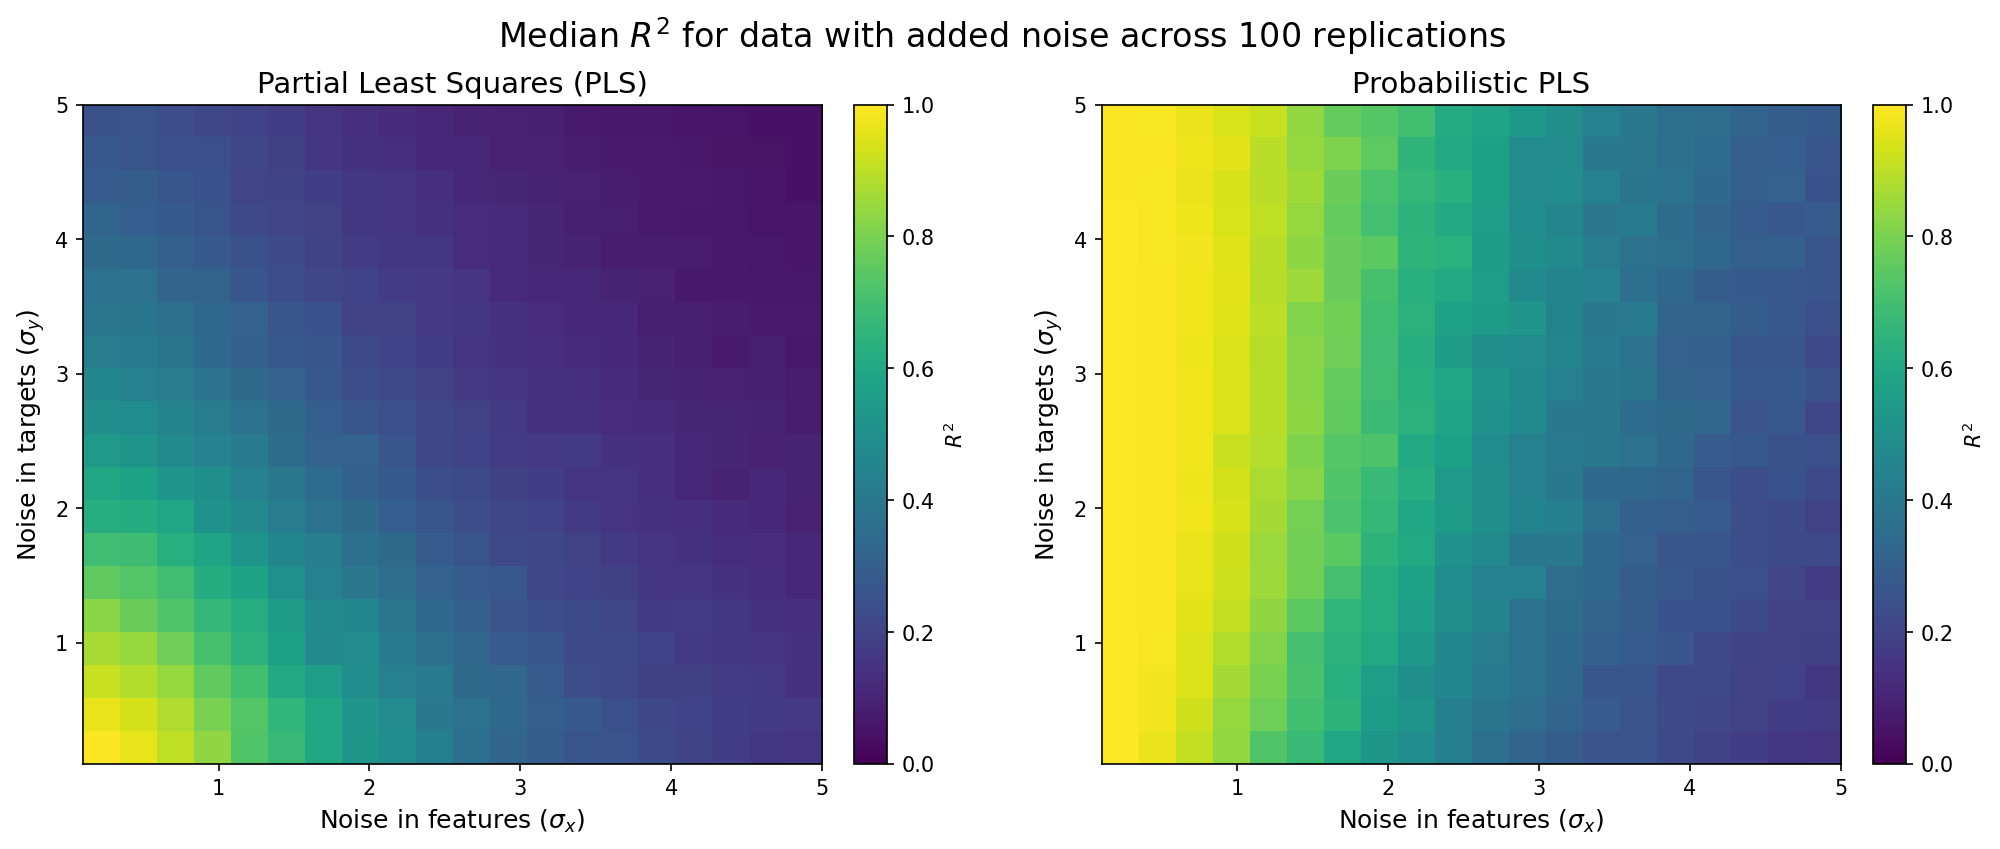

In [5]:
# Compute statistics across replications
r2_pls_median = np.median(r2_pls_results, axis = 2)
# r2_ppls_median = np.median(r2_ppls_results, axis = 2)
r2_stacked_median = np.median(r2_stacked_results, axis = 2)
tick_locations = np.linspace(0, 1, 11)

# Visualize results as heatmaps
plt.figure(figsize=(14, 6), dpi=150)
plt.suptitle("Median $R^2$ for data with added noise across " + str(n_replications) + " replications", fontsize = 16)

# PLS R-squared heatmap
plt.subplot(1, 2, 1)
im1 = plt.imshow(r2_pls_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto',
                 extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('Partial Least Squares (PLS)', fontsize=14)
plt.xlabel('Noise in features ($\\sigma_x$)', fontsize=12)
plt.ylabel('Noise in targets ($\\sigma_y$)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# # PPLS R-squared heatmap
# plt.subplot(1, 3, 2)
# im1 = plt.imshow(r2_ppls_median, origin='lower', cmap='viridis', aspect='auto',
#                  extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
# cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
# cbar1.ax.tick_params(labelsize=10)
# plt.title('PPLS R-squared', fontsize=14)
# plt.xlabel('Noise in $X$ ($\sigma_x$)', fontsize=12)
# plt.ylabel('Noise in $Y$ ($\sigma_y$)', fontsize=12)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

# Stacked PPLS R-squared heatmap
plt.subplot(1, 2, 2)
im2 = plt.imshow(r2_stacked_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto',
                 extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
cbar2 = plt.colorbar(im2, label='$R^2$', fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)
plt.title('Probabilistic PLS', fontsize=14)
plt.xlabel('Noise in features ($\\sigma_x$)', fontsize=12)
plt.ylabel('Noise in targets ($\\sigma_y$)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.88)
plt.savefig('noise_comparison_heatmap.png', bbox_inches='tight')
plt.show()

[30.314172175319143, 18.756908214993263]
[[0.22208286]
 [0.21996441]
 [0.21483406]
 [0.21376931]
 [0.21540676]
 [0.21854402]
 [0.22238139]
 [0.22647866]
 [0.23066461]
 [0.23492843]
 [0.23932879]
 [0.24393456]
 [0.24879299]
 [0.25391648]
 [0.25928107]
 [0.26483205]
 [0.27049351]
 [0.2761792 ]
 [0.28180275]
 [0.28728575]
 [0.29256291]
 [0.29758447]
 [0.3023162 ]
 [0.30673789]
 [0.31084109]
 [0.31462661]
 [0.31810223]
 [0.32128077]
 [0.32417844]
 [0.32681362]
 [0.3292058 ]
 [0.33137487]
 [0.33334055]
 [0.33512188]
 [0.33673703]
 [0.33820302]
 [0.33953563]
 [0.34074936]
 [0.34185741]
 [0.34287173]
 [0.34380305]
 [0.34466098]
 [0.34545407]
 [0.34618992]
 [0.34687524]
 [0.34751596]
 [0.34811729]
 [0.34868381]
 [0.34921954]
 [0.34972797]
 [0.35021217]
 [0.35067483]
 [0.35111826]
 [0.35154449]
 [0.35195528]
 [0.35235218]
 [0.35273649]
 [0.35310938]
 [0.35347184]
 [0.35382473]
 [0.35416882]
 [0.35450475]
 [0.35483308]
 [0.3551543 ]
 [0.35546884]
 [0.35577707]
 [0.35607931]
 [0.35637585]
 [0.356

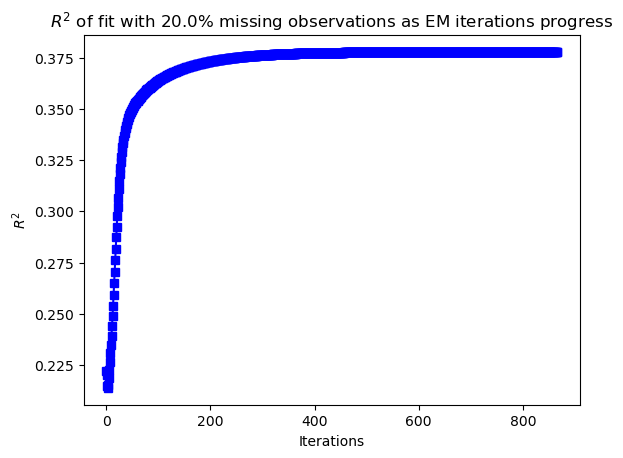

In [6]:
# Load new functions to deal with missing data
from PPLS import generate_synthetic_missing_data

# Generate data
proportion = 0.2
X, Y, F, P, Q = generate_synthetic_missing_data(n, p, q, k, sigma_x, sigma_y, proportion)

# Estimate PPLS imputing missing data within EM algorithm
ppls_missing_model = ProbabilisticPLS(n_components=k)
ppls_missing_model.fit(X, Y, standardize=False, track_r2=True)
print([ppls_missing_model.sigma2_x_, ppls_missing_model.sigma2_y_])
print(ppls_missing_model.r2_array_)

# Plot path of R-squared
plt.figure()
plt.plot(ppls_missing_model.r2_array_, "s-b")
plt.title("$R^2$ of fit with " + str(100*proportion) + "% missing observations as EM iterations progress")
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.show()

In [7]:
# Function to evaluate models over a range of percentage of missing observations
def evaluate_models_over_missing(n, p, q, k, missing_levels, n_replications):
    n_levels = len(missing_levels)
    r2_pls_full = np.zeros([n_levels, n_levels, n_replications])
    r2_ppls_full = np.zeros([n_levels, n_levels, n_replications])
    r2_missing_full = np.zeros([n_levels, n_levels, n_replications])
    r2_pls_imputed = np.zeros([n_levels, n_levels, n_replications])
    r2_ppls_imputed = np.zeros([n_levels, n_levels, n_replications])
    r2_missing_imputed = np.zeros([n_levels, n_levels, n_replications])

    for i, proportion_x in enumerate(missing_levels):
        for j, proportion_y in enumerate(missing_levels):
            for l in range(n_replications):
                # Generate synthetic data
                X, Y, _, _, _ = generate_synthetic_missing_data(n, p, q, k, sigma_x, sigma_y,
                                                                proportion_x, proportion_y, seed_value=None, return_nan=False)
                
                # Create imputed copies to compare with standard PLS and PPLS
                X_imputed = X.filled()
                Y_imputed = Y.filled()
                Y_full = np.copy(Y.data)
                
                # Apply PLS regression
                pls = PLSRegression(n_components=k)
                pls.fit(X_imputed, Y_imputed)
                Y_pred_pls = pls.predict(X_imputed)

                # Apply PPLS
                ppls_model = ProbabilisticPLS(n_components=k)
                ppls_model.fit(X_imputed, Y_imputed, standardize=False, track_r2=False)
                Y_pred_ppls = ppls_model.fitted(X_imputed, Y_imputed, standardize=False)

                # Apply PPLS with missing data
                X.data[X.mask] = np.nan
                Y.data[Y.mask] = np.nan
                missing_model = ProbabilisticPLS(n_components=k)
                missing_model.fit(X.data, Y.data, standardize=False, track_r2=False)
                Y_pred_missing = missing_model.fitted(X.data, Y_imputed, standardize=False)

                # Compute R-squared for all models (with respect to full matrix)
                r2_pls_full[i, j, l] = r2_score(Y_full, Y_pred_pls)
                r2_ppls_full[i, j, l] = r2_score(Y_full, Y_pred_ppls)
                r2_missing_full[i, j, l] = r2_score(Y_full, Y_pred_missing)

                # Compute R-squared for all models (with respect to imputed matrix)
                r2_pls_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_pls)
                r2_ppls_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_ppls)
                r2_missing_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_missing)


    return r2_pls_full, r2_ppls_full, r2_missing_full, r2_pls_imputed, r2_ppls_imputed, r2_missing_imputed

# Provide levels of missing observations and run function
n_replications = 100
missing_levels = np.linspace(0.0, 0.5, 20)
r2_pls_full, r2_ppls_full, r2_missing_full, r2_pls_imputed, r2_ppls_imputed, r2_missing_imputed = evaluate_models_over_missing(n, p, q, k, missing_levels, n_replications)

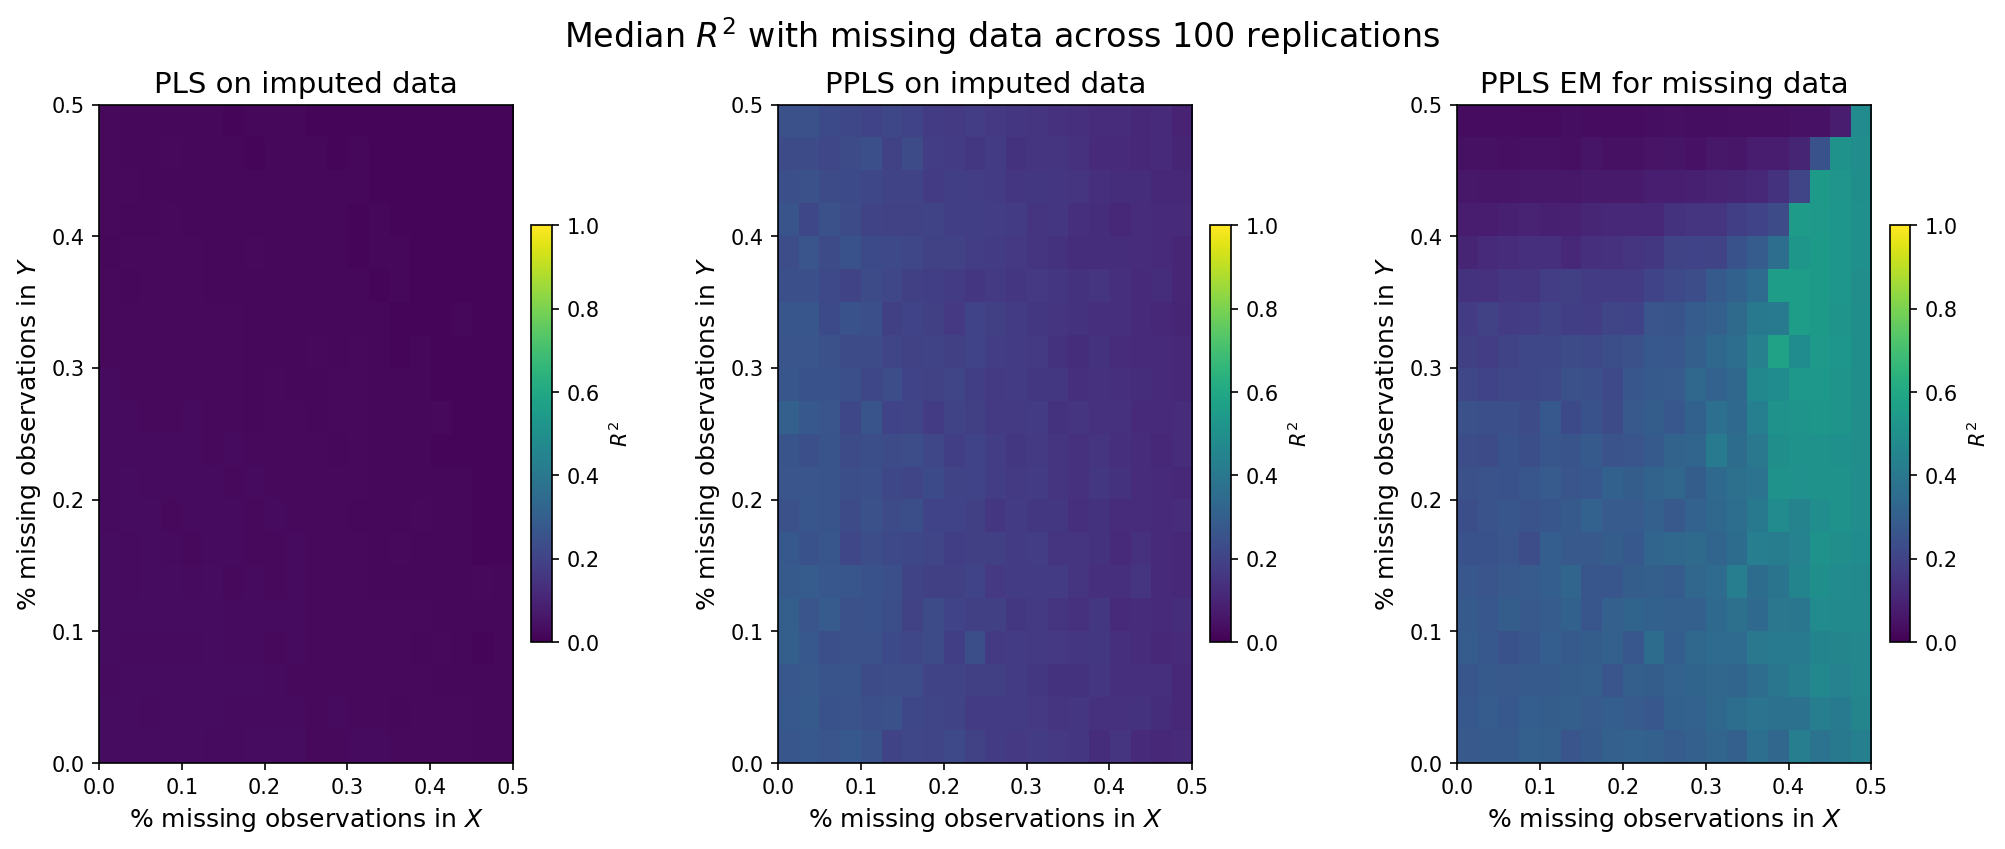

In [8]:
# Compute statistics across replications
r2_pls_full_median = np.median(r2_pls_full, axis = 2)
r2_ppls_full_median = np.median(r2_ppls_full, axis = 2)
r2_missing_full_median = np.median(r2_missing_full, axis = 2)
r2_pls_imputed_median = np.median(r2_pls_imputed, axis = 2)
r2_ppls_imputed_median = np.median(r2_ppls_imputed, axis = 2)
r2_missing_imputed_median = np.median(r2_missing_imputed, axis = 2)

# Visualize results as heatmaps
plt.figure(figsize=(14, 6), dpi=150)
plt.suptitle("Median $R^2$ with missing data across " + str(n_replications) + " replications", size = 16)
missing_range = variable_plot_range(missing_levels, percentage = 0)
missing_extent = [*missing_range, *missing_range]

# PLS R-squared heatmap
plt.subplot(1, 3, 1)
im2 = plt.imshow(r2_pls_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar2 = plt.colorbar(im2, label='$R^2$', fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)
plt.title('PLS on imputed data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# PPLS R-squared heatmap
plt.subplot(1, 3, 2)
im1 = plt.imshow(r2_ppls_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('PPLS on imputed data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Stacked PPLS R-squared heatmap
plt.subplot(1, 3, 3)
im1 = plt.imshow(r2_missing_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('PPLS EM for missing data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.88)
plt.savefig('missing_comparison_heatmap.png', bbox_inches='tight')
plt.show()